In [1]:
#load packages
import urllib2

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr, RFE, RFECV,SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV

In [4]:
response = urllib2.urlopen('https://ndownloader.figshare.com/files/7586326')
data_file = open('data.csv', 'w')
data_file.write(response.read())
data_file.close()

In [5]:
rent_df = pd.read_csv('data.csv', sep=',', header=0)

In [6]:
rent_df.head()

,recid,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,...,hflag4,hflag18,uf52h_h,uf52h_a,uf52h_b,uf52h_c,uf52h_d,uf52h_e,uf52h_f,uf52h_g
0,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
1,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,0,0,0,0
2,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,1,0,1,0
3,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
4,1,1,9,9,9,9,1,9,9,9,...,0,0,1,0,0,0,1,0,0,0


In [30]:
new_rentdf = rent_df[rent_df.uf17<5500]

In [31]:
data_x = new_rentdf.drop("uf17",1)
data_y = new_rentdf.ix[:,"uf17"]

In [35]:
data_x = preprocess(data_x)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3)

In [37]:
x_train_dummies = pd.get_dummies(x_train, columns=x_train.columns)

# Review of Feature Importance / Feature Selections

In [38]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(x_train_dummies, y_train)

/Users/hoadang/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/Users/hoadang/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


(0, 20)

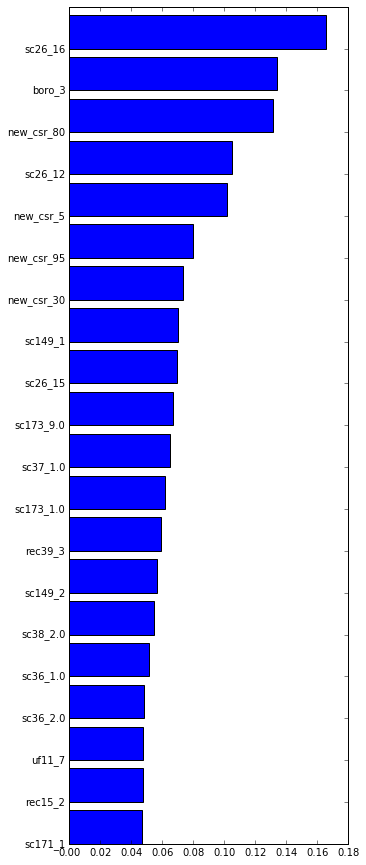

In [50]:
top_n = 20
inds = np.argsort(mi)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), mi[inds[-top_n:]])
plt.yticks(np.arange(top_n), x_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [42]:
from sklearn.feature_selection import f_regression
F, p = f_regression(x_train_dummies, y_train)

(0, 20)

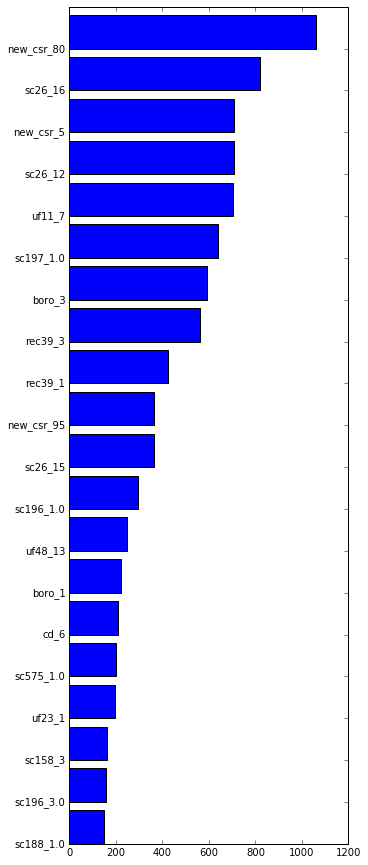

In [51]:
top_n = 20
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), x_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [45]:
cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)),
                x_train_dummies, y_train, cv=5)

array([ 0.58639169,  0.50581229,  0.56097355,  0.57572162,  0.47515546])

In [48]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(x_train_dummies, y_train)

(0, 20)

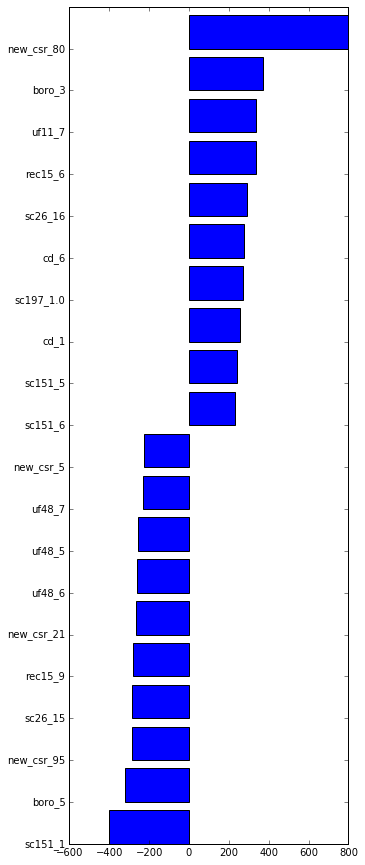

In [52]:
top_n = 20
coef = ridge.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), coef[inds])
plt.yticks(np.arange(top_n), x_train_dummies.columns[inds])
plt.ylim(0, top_n)

From several feature selection methods, we can see that the most important variable appear to be new_csr_80. I'd like to look further into this variable.

# Feature Breakdown: new_csr

In [54]:
data_x["new_csr"].value_counts()

80    3580
30    3532
31    1204
5      858
95     422
85     214
21     164
90     131
23      10
20      10
22       4
Name: new_csr, dtype: int64

In [55]:
codes = """01=Owner occupied conventional
02=Owner occupied private cooperative
05=Public housing
12=Owner occupied condo
20=Article 4 or 5 building
21=HUD regulated
22=Loft Board regulated building
23=Municipal Loan Program
30=Stabilized pre 1947
31=Stabilized post 1947
80=Other rental
85=Mitchell Lama rental
86=Mitchell Lama cooperative
87=Mitchell Lama type cooperative
90=Controlled
95=In Rem"""

In [64]:
code_dict = {int(code.split("=")[0]): code.split("=")[1] for code in codes.split("\n")}
data_x["new_csr"].value_counts().rename_axis(code_dict, axis=0)

Other rental                     3580
Stabilized pre 1947              3532
Stabilized post 1947             1204
Public housing                    858
In Rem                            422
Mitchell Lama rental              214
HUD regulated                     164
Controlled                        131
Municipal Loan Program             10
Article 4 or 5 building            10
Loft Board regulated building       4
Name: new_csr, dtype: int64

In [62]:
groups = data_y.groupby(data_x["new_csr"])

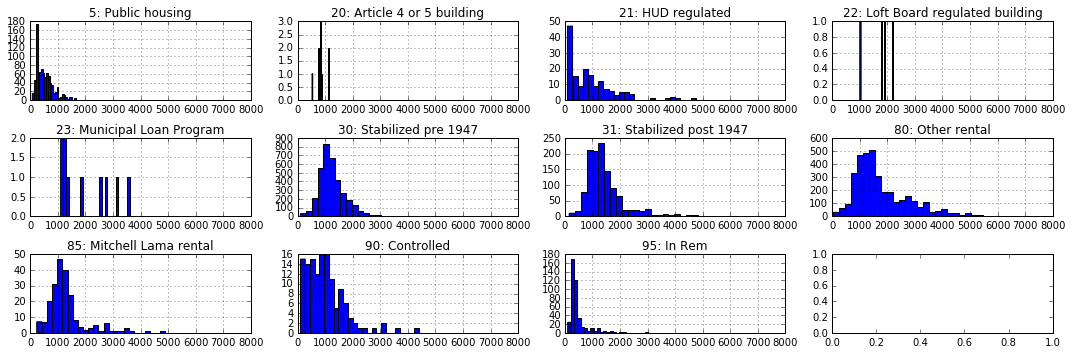

In [63]:
fig, axes = plt.subplots(3, len(groups) // 3 + 1, figsize=(15, 5))
for ax, (val, group) in zip(axes.ravel(), groups):
    group.hist(ax=ax, bins=25)
    ax.set_xlim(0, 8000)
    ax.set_title("{}: {}".format(val, code_dict[val]))

    plt.tight_layout()

Looks like code 80 are rents that are not stablized - thus it would make sense for us to only include these rents. Other rent stablized samples are not relevant to this analysis as to our goal of predicting the rents. 

In [66]:
not_stabilized = data_x["new_csr"] == 80
data_not_stabilized = data_x[not_stabilized]
y_not_stabilized = data_y[not_stabilized]

In [93]:
imp = Imputer(strategy="most_frequent").fit(data_not_stabilized)
X_mostfreq = imp.transform(data_not_stabilized)
    
x_mostfreq = pd.DataFrame(X_mostfreq)
x_mostfreq.columns = data_not_stabilized.columns

In [94]:
x_mostfreq.head(8)

,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,uf1_9,...,rec15,sc26,uf23,rec21,rec62,rec64,rec54,rec53,rec39,cd
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.0,16.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,16.0,9.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,16.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,16.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,16.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0
6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.0,16.0,9.0,1.0,1.0,1.0,4.0,5.0,3.0,1.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,16.0,7.0,1.0,1.0,1.0,5.0,5.0,3.0,1.0


In [95]:
x_train,x_test,y_train,y_test = train_test_split(x_mostfreq, y_not_stabilized)

In [96]:
x_train = pd.get_dummies(x_train)

# Fitting models

In [97]:
from sklearn.ensemble import RandomForestRegressor
cross_val_score(RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3),
                x_train, y_train, cv=5)

array([ 0.66231953,  0.61956391,  0.65718726,  0.66175364,  0.56301637])

We see a significant improvement in scoring from RidgeCV above, on the all rent types data set.

In [103]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.pipeline import make_pipeline 

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=30), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))
cross_val_score(pipe, x_train, y_train, cv=5)

array([ 0.53640393,  0.46870295,  0.49438022,  0.51205475,  0.43801959])

In [105]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=50), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))
param_grid = {'selectpercentile__percentile': [1, 5, 10, 20, 30, 50], 'polynomialfeatures__degree': [1, 2]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=50,
         score_func=<function f_regression at 0x1116bdf28>)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridgecv', RidgeCV(alpha...None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2], 'selectpercentile__percentile': [1, 5, 10, 20, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
grid.best_score_

0.52854672375570577

In [108]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'selectpercentile__percentile': 50}

# Helper and Prediction function using Lasso
 - Plug values in and get out results

In [34]:
def valuechange(data, col,n,k):
    #n is the value to be change, k is the replacing value
    temp = [k if x==n else x for x in list(data[col])]
    data[col] = temp

In [32]:
def preprocess(data): 
    
    # Drop Unnecessary Columns
    drops = ['uf6','seqno','recid','hhr2', 'hhr5', 'uf43', 'race1', 'uf2a',
        'uf2b', 'sc51', 'sc52', 'sc53', 'sc54', 'sc110', 'sc111', 'sc112',
        'sc113', 'sc115', 'sc116', 'sc117', 'sc118','sc120','sc121','uf5',
        'sc125','sc127','uf7','sc134','uf7a','uf9','sc140','sc141','sc143',
        'sc144','uf10','sc159','uf12','sc161','uf14','sc164','sc166','uf16',
        'sc174','uf64','sc181','sc541','sc184','sc542','sc543','sc544','uf17a',
        'sc548','sc549','sc550','sc551','sc570','sc574','sc560','uf53','uf54',
        'uf19','sc27','rec1','uf46','rec4','rec_race_a','rec_race_c',
         'tot_per','rec28','uf26','uf28','uf27','uf42','uf42a','uf34','uf34a',
         'uf35','uf35a','uf36','uf36a','uf37','uf37a','uf38','uf38a','uf39','uf39a',
        'uf40','uf40a','uf30','uf29','rec8','rec7','fw','chufw','flg_sx1','flg_ag1',
       'flg_hs1','flg_rc1','hflag2','hflag1','hflag13','hflag9','hflag10','hflag91',
        'hflag11','hflag12','hflag18','uf52h_h','uf52h_a','uf52h_b','uf52h_c',
        'uf52h_d','uf52h_e','uf52h_f','uf52h_g','uf8','uf13','uf15','hflag6',
        'hflag3', 'hflag14', 'hflag16', 'hflag7', 'hflag4']
    
    new_data = data.drop(drops, axis=1)
    
    # Find None Values
    change8_to_none = ['sc23', 'sc24', 'sc36', 'sc37', 'sc38','sc147',
                   'sc154','sc157','sc185','sc186','sc187','sc188','sc198',
                 'sc190','sc191','sc192','sc194','sc196','sc199','sc575',
                   'rec21','sc173','sc197','sc571','sc189']

    for col in change8_to_none: 
        valuechange(new_data, col,8,None)


    change89 = ['uf1_1', 'uf1_2', 'uf1_3', 'uf1_4', 'uf1_5', 'uf1_6',
               'uf1_7', 'uf1_8', 'uf1_9', 'uf1_10', 'uf1_11', 'uf1_12',
               'uf1_13', 'uf1_14', 'uf1_15', 'uf1_16', 'uf1_35', 'uf1_17',
               'uf1_18', 'uf1_19', 'uf1_20', 'uf1_21', 'uf1_22']

    for col in change89:
        valuechange(new_data, col,8,None)
        valuechange(new_data, col,9,0)

    # Other one-off value changes
    valuechange(new_data, 'sc173',3,None)
    valuechange(new_data, 'sc197',4,None)
    valuechange(new_data, 'sc571',5,None)
    valuechange(new_data, 'sc193',9,3)
    valuechange(new_data, 'rec54',7,None)
    valuechange(new_data, 'rec53',9,None)
    
    return new_data

In [109]:
def make_pipeline(x_data, y_data):
    
    #new_data = preprocess(x_data)
    new_data = x_data
    
    # Impute Missing Data 
    imp = Imputer(strategy="most_frequent").fit(new_data)
    X_mostfreq = imp.transform(new_data)
    
    mod_data = pd.DataFrame(X_mostfreq)
    mod_data.columns = new_data.columns
    
    for col in mod_data.columns.tolist():
        mod_data[col] = mod_data[col].astype("category")
           
    rfe = RFE(Lasso(),50) #Recursive Feature Selections for top 50 features
    rfe.fit(mod_data,y_data)
    
    mod_data = mod_data.ix[:,mod_data.columns[rfe.support_]]
    
    #Transform X train to polynomial features
    poly = PolynomialFeatures()
    x_poly = poly.fit_transform(mod_data)
    
    model = RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3) #iteration set to 10000 to ensure convergence
    model.fit(x_poly, y_data)
    
    return (imp, rfe, poly, model)

In [86]:
def transform_data(data, imp, rfe, poly, model):
    transform_data = x_test
    
    imputed_data = imp.transform(transform_data)
    
    imputed_data = pd.DataFrame(imputed_data)
    
    imputed_data.columns = transform_data.columns
    
    for col in imputed_data.columns.tolist():
        imputed_data[col] = imputed_data[col].astype("category")
    
    imputed_data = imputed_data.ix[:,imputed_data.columns[rfe.support_]]
    
    poly_data = poly.fit_transform(imputed_data)     
    
    return poly_data

In [87]:
def predict(x_test, imp, rfe, poly, model): 
    data_transform = transform_data(x_test, imp, rfe, poly, model)
    
    return model.predict(data_transform)

def predict_rent(x_test, y_true, imp, rfe, poly, model):
    prediction_output = predict(x_test, imp, rfe, poly, model)
    return {"data":x_test, "y_predict":prediction_output, "y_true":y_true}

In [88]:
def score_rent(x_test, y_test, imp, rfe, poly, model):
    data_transform = transform_data(x_test, imp, rfe, poly, model)
    return model.score(data_transform, y_test)

In [110]:
(imp, rfe, poly, model) = make_pipeline(x_train, y_train)

In [111]:
prediction_output = predict_rent(x_test, y_test, imp, rfe, poly, model)
print (score_rent(x_test, y_test, imp, rfe, poly, model))

0.67111739571
